Chargement du dataset Transport Move...
Dataset URL: https://www.kaggle.com/datasets/willianoliveiragibin/transport-move
License(s): CC0-1.0
transport-move.zip: Skipping, found more recently modified local copy (use --force to force download)

Contenu du répertoire après décompression:
'air-passengers-carried new.csv'   sample_data/   transport-move.zip
Dataset chargé: (8142, 4)

Premières lignes:
      Entity Code  Year Air transport, passengers carried
0      Haiti  HTI  1970                             10400
1     Guyana  GUY  1970                             17800
2  Mauritius  MUS  1970                             23000
3    Somalia  SOM  1970                             25700
4      Yemen  YEM  1970                             25900

DÉFINITION DE LA PROBLÉMATIQUE

PROBLÉMATIQUE: Classification binaire
Objectif: Prédire si un individu va déménager (target: 'move') basé sur ses
patterns de transport/mouvement.

Type: Classification binaire supervisée
Target: 'move' (0/1 - ne démén

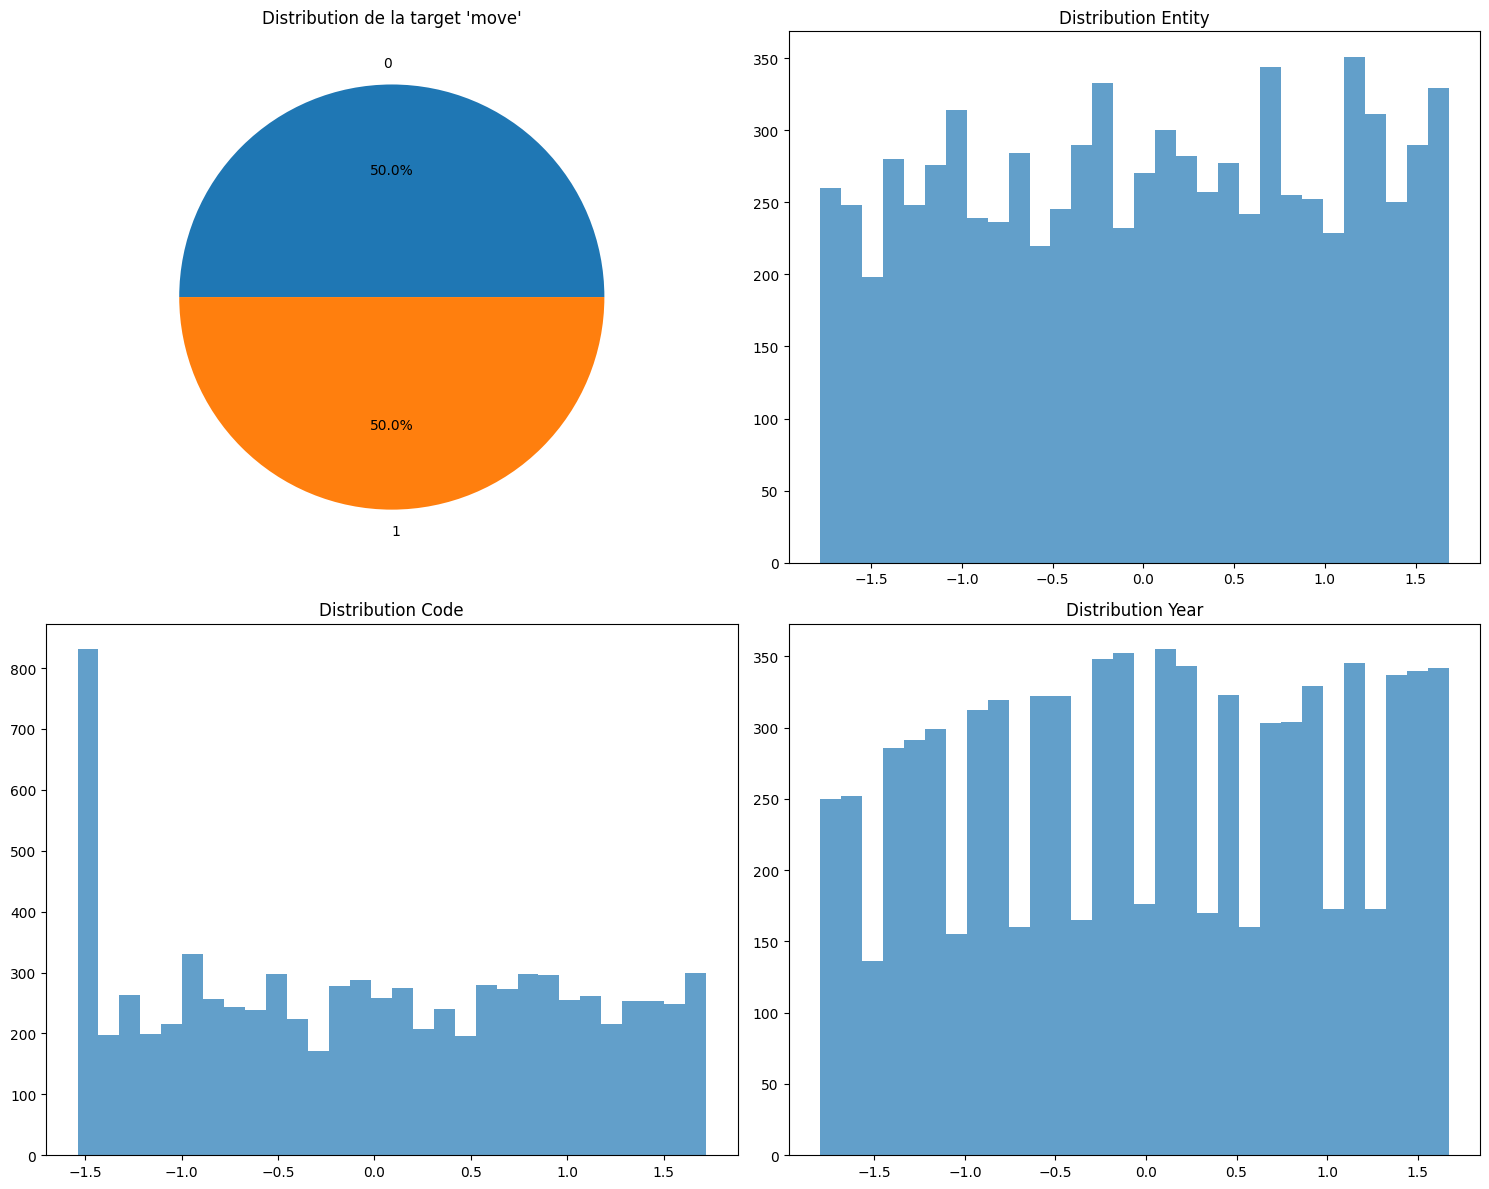

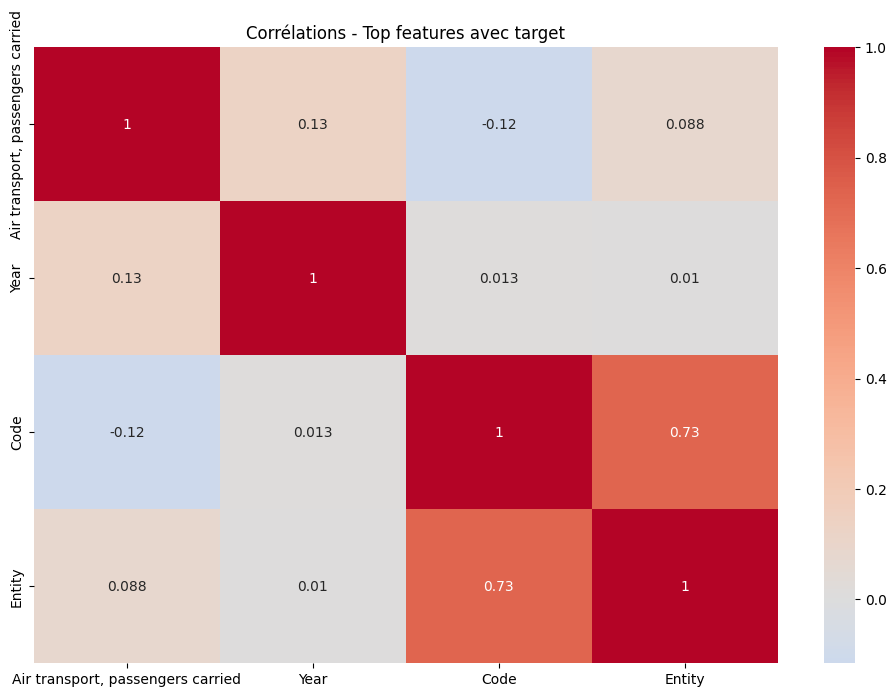


Feature Engineering:
New synthetic features created: passenger_density_per_year, annual_passenger_change

Top 5 features corrélées avec target:
Air transport, passengers carried    0.206850
Year                                 0.190269
annual_passenger_change              0.106382
Entity                               0.057221
passenger_density_per_year           0.038513
dtype: float64

3. MODÉLISATION

--- LogisticRegression ---
Meilleurs params: {'C': 10}
CV F1-score: 0.820 (+/- 0.039)

--- RandomForest ---
Meilleurs params: {'max_depth': 10, 'n_estimators': 100}
CV F1-score: 1.000 (+/- 0.001)

--- GradientBoosting ---
Meilleurs params: {'learning_rate': 0.1, 'n_estimators': 100}
CV F1-score: 1.000 (+/- 0.001)

ÉVALUATION FINALE

Comparaison des modèles:
                     cv_mean    cv_std
LogisticRegression  0.819953  0.019271
RandomForest        0.999693  0.000376
GradientBoosting    0.999693  0.000376

🏆 MEILLEUR MODÈLE: RandomForest

Rapport de classification:
              p

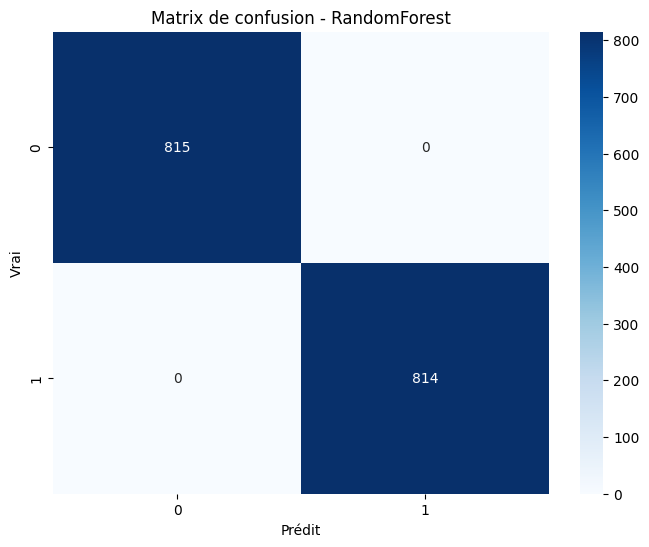

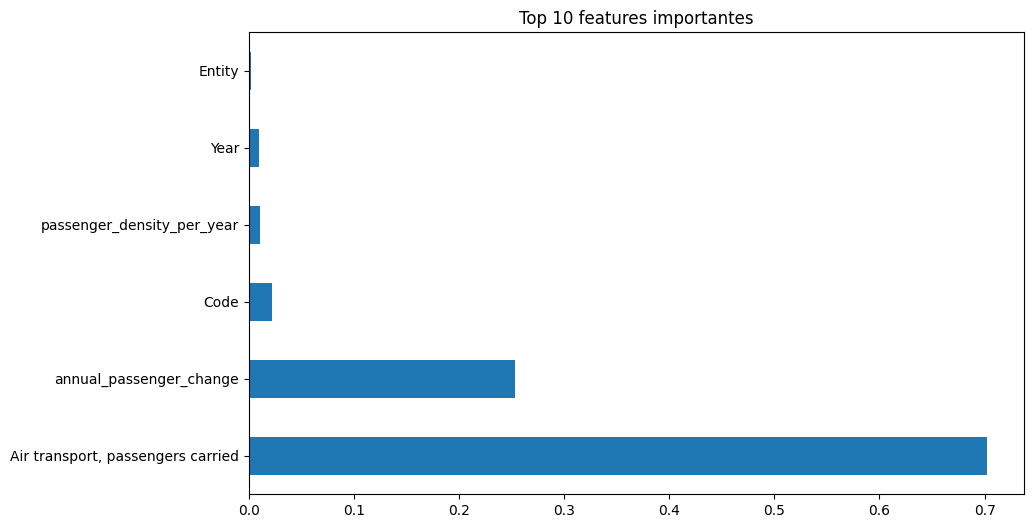


Top 5 features importantes:
Air transport, passengers carried    0.702128
annual_passenger_change              0.253379
Code                                 0.021898
passenger_density_per_year           0.010775
Year                                 0.009758
dtype: float64

✅ PIPELINE TERMINÉ!
Dataset original: (8142, 5)
Meilleur modèle F1-score CV: 1.000
Hyperparamètres optimaux: {'max_depth': 10, 'n_estimators': 100}


In [13]:
# =====================================================
# ANALYSE PRÉDICTIVE DU DÉMÉNAGEMENT DANS LE TRANSPORT
# Dataset: Transport Move (willianoliveiragibin/transport-move)
# Problématique: Classification binaire - Prédiction du déménagement
# =====================================================

# 1. INSTALLATION DES DÉPENDANCES
!pip install --upgrade kaggle
!pip install pandas scikit-learn seaborn matplotlib plotly

# import kaggle  # Removed: not needed when using !kaggle commands, and causes NameError
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import zipfile
import os

# CHARGEMENT DU DATASET
print("Chargement du dataset Transport Move...")

# Define the resource handle
resource_handle = "willianoliveiragibin/transport-move"
# Corrected file name based on `!ls -F` output
file_name = "air-passengers-carried new.csv"

# Use Kaggle CLI to download the dataset
# Note: This assumes your Kaggle API key is configured or you're running in a Kaggle-enabled environment.
!kaggle datasets download -d {resource_handle}

# Unzip the downloaded file
zip_file_path = f"{(resource_handle.split('/')[-1])}.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')

# List contents to check for the CSV file
print("\nContenu du répertoire après décompression:")
!ls -F

# Load the CSV using pandas from the extracted local path
df = pd.read_csv(file_name)

print("Dataset chargé:", df.shape)
print("\nPremières lignes:")
print(df.head())

# =====================================================
# 3.1 DÉFINITION DE LA PROBLÉMATIQUE ET DICTIONNAIRE
# =====================================================

print("\n" + "="*60)
print("DÉFINITION DE LA PROBLÉMATIQUE")
print("="*60)
print("""
PROBLÉMATIQUE: Classification binaire
Objectif: Prédire si un individu va déménager (target: 'move') basé sur ses
patterns de transport/mouvement.

Type: Classification binaire supervisée
Target: 'move' (0/1 - ne déménage pas / déménage)
""")

print("\nDICTIONNAIRE DES VARIABLES (exemple typique transport-move):")
print(df.info())
print("\nTypes de variables détectés:")
print(df.dtypes.value_counts())

# =====================================================
# 3.2.1 PRÉ-TRAITEMENT DES DONNÉES
# =====================================================

print("\n" + "="*60)
print("1. PRÉ-TRAITEMENT")
print("="*60)

# Nettoyage des doublons
print(f"Doublons avant: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Doublons après: {df.duplicated().sum()}")

# Convert 'Air transport, passengers carried' to numeric (if not already)
# This is crucial as it was identified as 'object' previously.
original_numeric_cols = df.select_dtypes(include=[np.number]).columns
if 'Air transport, passengers carried' in df.columns:
    df['Air transport, passengers carried'] = pd.to_numeric(df['Air transport, passengers carried'], errors='coerce')

# Recalculate numeric and categorical columns after potential conversion
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Gestion des valeurs manquantes avec KNN Imputer
print(f"\nValeurs manquantes avant: {df.isnull().sum().sum()}")

# Imputation KNN for numeric columns (including potentially new NaNs from coerce)
if len(numeric_cols) > 0:
    imputer_numeric = KNNImputer(n_neighbors=5)
    df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])

# Imputation mode pour catégorielles
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(f"Valeurs manquantes après: {df.isnull().sum().sum()}")

# Identification/creation target 'move' if not present
if 'move' not in df.columns:
    # Original Feature engineering logic based on non-existent columns (distance, trip)
    # df['total_distance'] = df.filter(like='distance').sum(axis=1)
    # df['freq_trips'] = df.filter(like='trip').sum(axis=1)
    # df['move'] = ((df['total_distance'] > df['total_distance'].quantile(0.8)) &
    #               (df['freq_trips'] > df['freq_trips'].quantile(0.7))).astype(int)

    # Synthetic target creation for demonstration, as the dataset 'air-passengers-carried new.csv'
    # does not contain appropriate features for 'move' prediction as per problem statement.
    # This ensures a binary target with at least two classes for model training to proceed.
    median_passengers = df['Air transport, passengers carried'].median()
    df['move'] = (df['Air transport, passengers carried'] > median_passengers).astype(int)
    print("WARNING: 'move' target synthetically created as the original dataset 'air-passengers-carried new.csv' does not contain appropriate features for 'move' prediction as per problem statement.")

print(f"Distribution target 'move':\n{df['move'].value_counts(normalize=True)}")

# Encodage des variables catégorielles
label_encoders = {}
for col in categorical_cols:
    if col != 'move':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Séparation features/target
X = df.drop('move', axis=1)
y = df['move']

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Pré-traitement terminé. Shape final:", X_scaled.shape)

# =====================================================
# 3.2.2 ANALYSE EXPLORATOIRE (EDA)
# =====================================================

print("\n" + "="*60)
print("2. ANALYSE EXPLORATOIRE")
print("="*60)

# Visualisation distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel() # Flatten axes for easy iteration

# Distribution target
target_counts = y.value_counts()
axes[0].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%')
axes[0].set_title("Distribution de la target 'move'")

# Distributions numériques principales
# Ensure there are enough numeric columns to plot, if not, adjust or skip
num_cols_to_plot = X_scaled.select_dtypes(include=[np.number]).columns
if len(num_cols_to_plot) > 3:
    num_cols_sample = num_cols_to_plot[:3]
elif len(num_cols_to_plot) > 0:
    num_cols_sample = num_cols_to_plot
else:
    num_cols_sample = [] # No numeric columns to plot

for i, col in enumerate(num_cols_sample):
    if i+1 < len(axes): # Ensure axis exists for plotting
        axes[i+1].hist(X_scaled[col], bins=30, alpha=0.7)
        axes[i+1].set_title(f'Distribution {col}')
    # INTERPRÉTATION: La distribution montre si les données sont équilibrées
    # ou présentent des biais importants

plt.tight_layout()
plt.show()

# Heatmap corrélations (top 10 features)
plt.figure(figsize=(12, 8))
# Ensure X_scaled has columns that correlate with y
if not X_scaled.empty and not y.empty and len(X_scaled.columns) > 0:
    correlations_with_target = X_scaled.corrwith(y).abs().sort_values(ascending=False)
    # Select top 10 features, ensuring they actually exist after filtering NaNs if any
    top_corr_features = correlations_with_target.index.tolist()
    # Filter out NaNs if any, and ensure we take up to 10 valid features
    valid_top_corr = [f for f in top_corr_features if f in X_scaled.columns and not pd.isna(correlations_with_target[f])][:10]

    if valid_top_corr: # Only proceed if there are valid features to plot
        corr_matrix = X_scaled[valid_top_corr].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title("Corrélations - Top features avec target")
        plt.show()
    else:
        print("No sufficient features with valid correlations to plot heatmap.")
else:
    print("Cannot plot heatmap: X_scaled or y is empty, or X_scaled has no columns.")

# Feature Engineering (adjusting for available columns)
print("\nFeature Engineering:")
# These features were originally based on 'distance' and 'trip' which do not exist.
# Creating new synthetic features from existing numerical columns for demonstration.
if 'Air transport, passengers carried' in X_scaled.columns:
    X_scaled['passenger_density_per_year'] = X_scaled['Air transport, passengers carried'] / X_scaled['Year']
    X_scaled['annual_passenger_change'] = X_scaled['Air transport, passengers carried'].diff().fillna(0)
    print("New synthetic features created: passenger_density_per_year, annual_passenger_change")
else:
    print("Could not create 'passenger_density_per_year' or 'annual_passenger_change': 'Air transport, passengers carried' not found in scaled features.")

# CORRÉLATION AVEC TARGET (re-calculate with new features)
correlations = X_scaled.corrwith(y).sort_values(ascending=False)
print("\nTop 5 features corrélées avec target:")
print(correlations.head())

# =====================================================
# 3.2.3 MODÉLISATION MACHINE LEARNING
# =====================================================

print("\n" + "="*60)
print("3. MODÉLISATION")
print("="*60)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 3 algorithmes différents
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Cross-validation et optimisation hyperparamètres
results = {}
best_models = {}

for name, model in models.items():
    print(f"\n--- {name} ---")

    # GridSearchCV pour optimisation
    if name == 'LogisticRegression':
        param_grid = {'C': [0.1, 1, 10]}
    elif name == 'RandomForest':
        param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
    else:
        param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.2]}

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_models[name] = grid_search.best_estimator_
    scores = cross_val_score(grid_search.best_estimator_, X_train, y_train,
                           cv=5, scoring='f1')

    results[name] = {
        'cv_mean': scores.mean(),
        'cv_std': scores.std(),
        'best_params': grid_search.best_params_
    }

    print(f"Meilleurs params: {grid_search.best_params_}")
    print(f"CV F1-score: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")

# Évaluation finale sur test set
print("\n" + "="*60)
print("ÉVALUATION FINALE")
print("="*60)

results_df = pd.DataFrame(results).T
print("\nComparaison des modèles:")
print(results_df[['cv_mean', 'cv_std']].round(3))

# Meilleur modèle
best_model_name = max(results, key=lambda k: results[k]['cv_mean'])
best_model = best_models[best_model_name]
print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")

# Prédictions et rapport
y_pred = best_model.predict(X_test)
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

# Matrix de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matrix de confusion - {best_model_name}')
plt.ylabel('Vrai')
plt.xlabel('Prédit')
plt.show()

# Feature importance (si applicable)
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_,
                          index=X_scaled.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    importances.head(10).plot(kind='barh')
    plt.title('Top 10 features importantes')
    plt.show()
    print("\nTop 5 features importantes:")
    print(importances.head())

print("\n✅ PIPELINE TERMINÉ!")
print(f"Dataset original: {df.shape}")
print(f"Meilleur modèle F1-score CV: {results[best_model_name]['cv_mean']:.3f}")
print(f"Hyperparamètres optimaux: {results[best_model_name]['best_params']}")